In [41]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [42]:
# loading the dataset 
data = pd.read_csv("visa_data.csv")
df_copy  = data.copy()

In [43]:
df_copy.head()

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified


                       Correlation Coefficient
education_of_employee                 0.318189
unit_of_wage                          0.207528
has_job_experience                    0.192162
Quality_Rating                        0.191806
prevailing_wage                       0.168009
continent                             0.105613
Prev_wage_normal                      0.084993
region_of_employment                  0.053490
no_of_employees                       0.027558
full_time_position                    0.012711
age_of_estab                          0.008597
yr_of_estab                           0.008597
yr_of_estab_str                       0.008481
requires_job_training                 0.008423


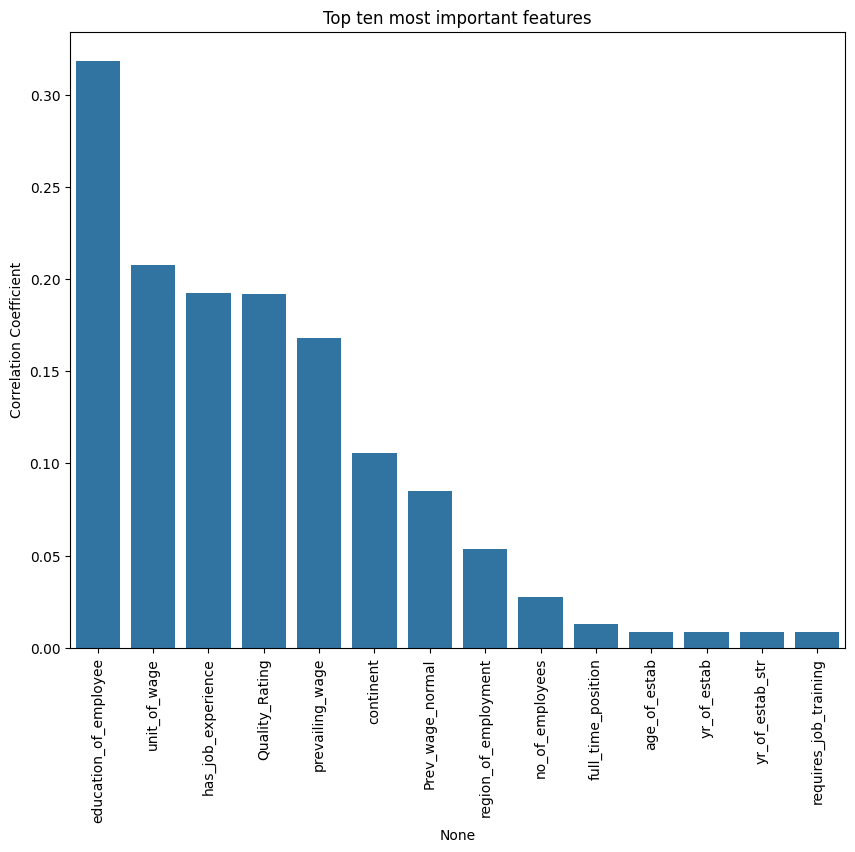

In [ ]:
def data_preprocessing(data, current_year = 2025):  
    """
    data: pd.DataFrame
    
    Output
    processed_data:pd.DataFrame
    """
    #Handle negative values in "no_of_employees"
    data["no_of_employees"] = np.abs(data["no_of_employees"])
    data = data.drop("case_id", axis = 1)

    #Feature engineering
    def prev_wage_norm(data):
        if data["unit_of_wage"] == "Year":
            return data["prevailing_wage"]
        elif data["unit_of_wage"] == "Month":
            return data["prevailing_wage"] * 12
        elif data["unit_of_wage"] == "Week":
            return data["prevailing_wage"] * 52
        else:
            return data["prevailing_wage"] * 40 * 52
    
    data["Prev_wage_normal"] = data.apply(prev_wage_norm, axis = 1)
    data["age_of_estab"] = current_year - data["yr_of_estab"]

    def quality_assessment(data):
        if data["has_job_experience"] == "Y" and data["requires_job_training"] == "Y":
            return 4
        elif data["has_job_experience"] == "Y" and data["requires_job_training"] == "N":
            return 3
        elif data["has_job_experience"] == "N" and data["requires_job_training"] == "Y":
            return 2
        else:
            return 1
        
    data["Quality_Rating"]  = data.apply(quality_assessment, axis = 1)

    data["education_of_employee"] = data["education_of_employee"].map({"High School": 0, "Bachelor's": 1, "Master's": 2, "Doctorate": 3})

    data["continent"] = data["continent"].map({"South America": 0, "North America": 1, "Oceania": 2, "Asia": 3, "Africa": 4, "Europe": 5})

    obj_cols = [x for x in data.columns if data[x].dtype in ["category", object]]
    
    encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
    

    data["yr_of_estab_str"] = data["yr_of_estab"].astype(str)
    num_cols = ["no_of_employees", "prevailing_wage"]
    obj_cols = [x for x in data.columns if data[x].dtype == object]
    obj_cols.remove("case_status")
    data["case_status"] = data["case_status"].map({"Denied": 0, "Certified": 1})
    for i in num_cols:
        data[i] = np.log(data[i])
    data[obj_cols] = encoder.fit_transform(data[obj_cols])

    corr_df = pd.DataFrame({"Correlation Coefficient": np.abs(data.corrwith(data["case_status"]))})
    corr_df_sorted = corr_df.sort_values("Correlation Coefficient", ascending=False).iloc[:, :10]
    corr_df_sorted = corr_df_sorted.iloc[1:]
    print(corr_df_sorted)

    plt.figure(figsize=(10,8))
    plt.title("Top ten most important features")
    sns.barplot(x = corr_df_sorted.index, y=corr_df_sorted["Correlation Coefficient"])
    plt.tick_params(axis="x", labelrotation = 90)
    plt.show()

    joblib.dump(encoder, "encoder.pkl")
    return data

pre_processed = data_preprocessing(data)


In [45]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler

X, y = pre_processed.drop("case_status", axis =1), pre_processed["case_status"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

smote = SMOTE(random_state=0)
X_train, y_train = smote.fit_resample(X_train, y_train)

#Save files
X_train.to_csv("X_train.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

